<a href="https://colab.research.google.com/github/aai530-group6/project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

**Requirements**
- Project must include 2 models
- At least one using deep learning
- At least one time series prediction


**Notes**
- Build a LSTM to predict 'overall_score' based on other features (satisfies deep learning & time series req.)
- Build a traditional ML classifier to classify important features as bad, average or good for daily notifications in a smart watch




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
# Feature importance
from sklearn.ensemble import RandomForestRegressor
# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LambdaCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/sleep_score.csv')

#Exploratory Data Analysis

In [ ]:
df.head(1)

,timestamp,overall_score,revitalization_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2023-11-18T07:59:00Z,83,83,104,63,0.0681


In [ ]:
# Datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values('timestamp', inplace=True)

In [ ]:
# Missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 timestamp                0
overall_score            0
revitalization_score     0
deep_sleep_in_minutes    0
resting_heart_rate       0
restlessness             0
dtype: int64


In [ ]:
df.describe()

,overall_score,revitalization_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
count,291.000000,291.000000,291.000000,291.000000,291.000000
mean,75.189003,75.189003,91.292096,62.171821,0.067268
std,7.614552,7.614552,28.807337,2.831722,0.021966
min,45.000000,45.000000,18.000000,55.000000,0.032702
25%,70.000000,70.000000,69.500000,60.000000,0.052605
50%,76.000000,76.000000,91.000000,62.000000,0.062626
75%,81.500000,81.500000,110.500000,64.000000,0.077261
max,89.000000,89.000000,179.000000,70.000000,0.185596


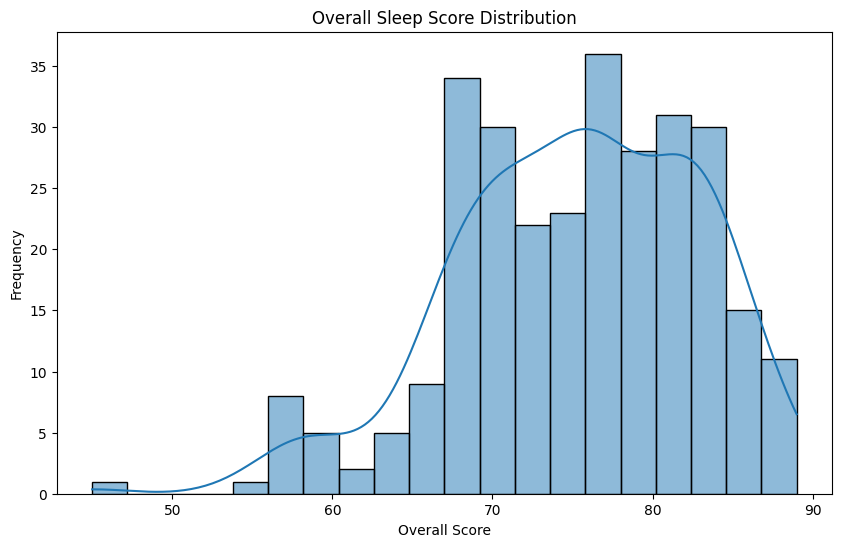

In [ ]:
# Distribution of Overall Sleep Score
plt.figure(figsize=(10, 6))
sns.histplot(df['overall_score'], kde=True, bins=20)
plt.title('Overall Sleep Score Distribution')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.show()

<ipython-input-9-505e2d532d6e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")


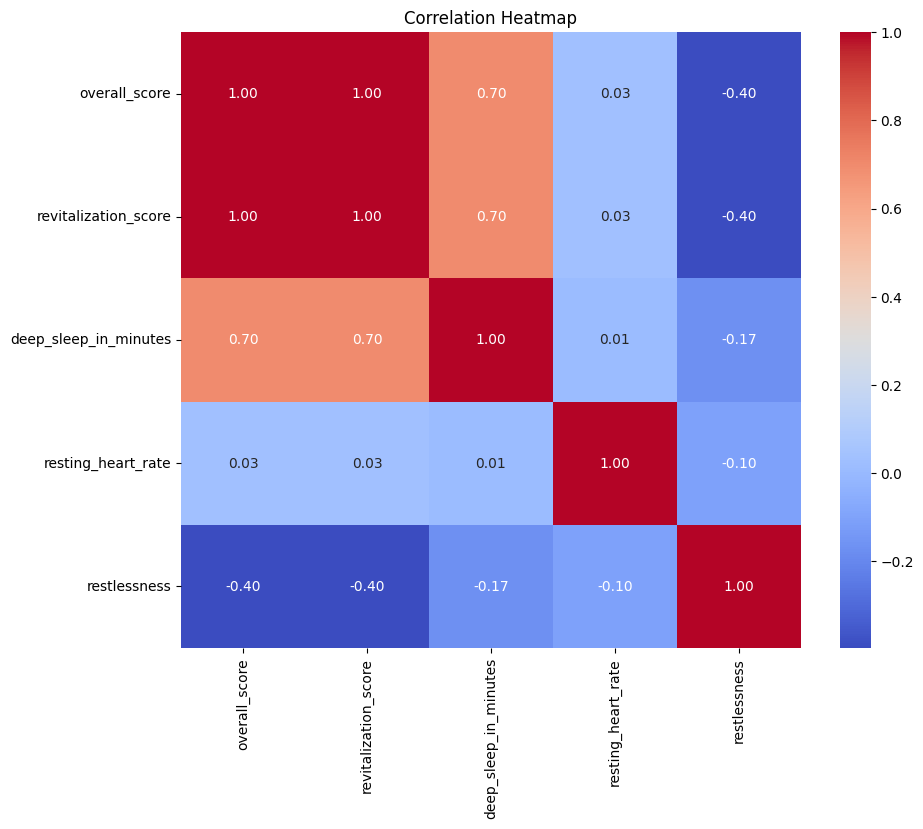

In [ ]:
## Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Notes

- Target variable: 'overall_score'
- 'deep_sleep_in_minutes' has a high correlation of 0.70
- 'restlessness' has a notable negative correlation of -0.40

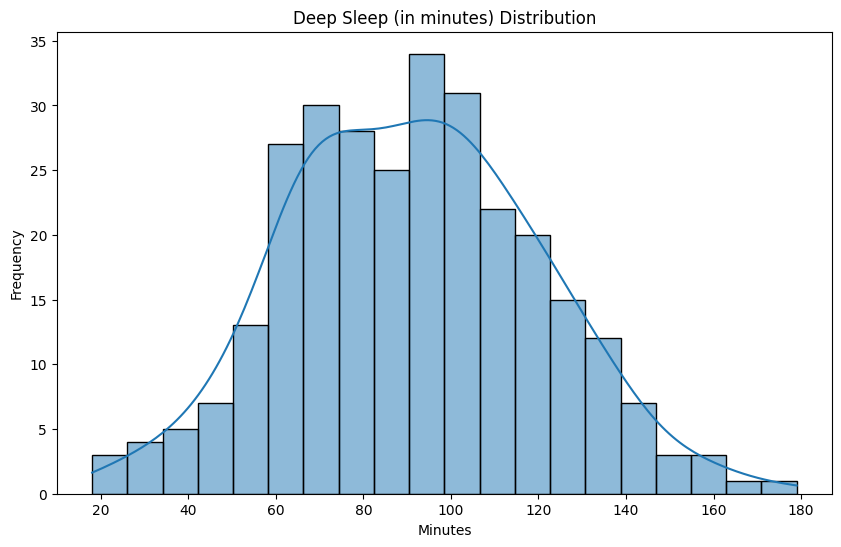

In [ ]:
# Distribution of Deep Sleep
plt.figure(figsize=(10, 6))
sns.histplot(df['deep_sleep_in_minutes'], kde=True, bins=20)
plt.title('Deep Sleep (in minutes) Distribution')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

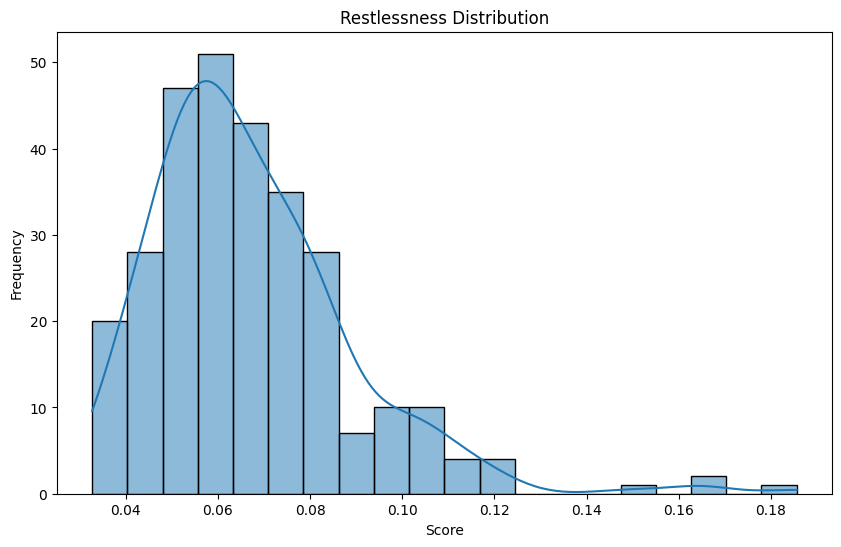

In [ ]:
# Distribution of Restlessness
plt.figure(figsize=(10, 6))
sns.histplot(df['restlessness'], kde=True, bins=20)
plt.title('Restlessness Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Feature Engineering

- Add lagged features
- Add noise

In [ ]:
# Lag features for 'deep_sleep_in_minutes' and 'overall_score'
for lag in range(1, 8):
    df[f'deep_sleep_in_minutes_lag{lag}'] = df['deep_sleep_in_minutes'].shift(lag)
    df[f'overall_score_lag{lag}'] = df['overall_score'].shift(lag)

# Drop rows with NaN values created by lagging
df.dropna(inplace=True)

In [ ]:
# Add noise to features (excluding 'timestamp' and 'overall score')
noise_strength = 0.01
features_to_noise = ['deep_sleep_in_minutes', 'resting_heart_rate', 'restlessness'] + [f'deep_sleep_in_minutes_lag{lag}' for lag in range(1, 8)]
for feature in features_to_noise:
    df[feature] += np.random.normal(0, noise_strength, df.shape[0])

# LSTM

In [ ]:
# Sequence length: 7 days to capture weekly patterns
# Predictive horizon: 1 day to predict next day's overall sleep score
sequence_length = 7
predictive_horizon = 1

In [ ]:
# Set target, features, and exclude 'revitalization_score' due to 1.0 correlation with target
features_columns = ['deep_sleep_in_minutes', 'resting_heart_rate', 'restlessness'] + \
                   [f'deep_sleep_in_minutes_lag{lag}' for lag in range(1, 8)] + \
                   [f'overall_score_lag{lag}' for lag in range(1, 8)]

features = df[features_columns]
target = df['overall_score']

In [ ]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
X = []
y = []

for i in range(len(scaled_features) - sequence_length):
    X.append(scaled_features[i:i + sequence_length])
    y.append(target.iloc[i + sequence_length])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
#LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units=1, kernel_regularizer=l2(0.01)))

model.compile(optimizer=Adam(learning_rate=0.0009), loss='mean_squared_error', metrics=['mae', 'mse'])

# Print every 10
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch: {epoch+1}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")
    if (epoch + 1) % 10 == 0 else None
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=20,
    validation_data=(X_val, y_val),
    verbose=0,
    callbacks=[print_callback]
)

Epoch: 10, Loss: 487.4626770019531, Val Loss: 190.6942138671875
Epoch: 20, Loss: 359.4826354980469, Val Loss: 129.1096649169922
Epoch: 30, Loss: 308.6536560058594, Val Loss: 89.75335693359375
Epoch: 40, Loss: 330.34619140625, Val Loss: 78.61197662353516
Epoch: 50, Loss: 288.6123046875, Val Loss: 72.86920166015625
Epoch: 60, Loss: 285.0083923339844, Val Loss: 64.79359436035156
Epoch: 70, Loss: 298.71771240234375, Val Loss: 85.46919250488281
Epoch: 80, Loss: 249.99452209472656, Val Loss: 61.384830474853516
Epoch: 90, Loss: 315.3197937011719, Val Loss: 102.67457580566406
Epoch: 100, Loss: 319.2215576171875, Val Loss: 67.99555206298828


In [ ]:
test_loss = model.evaluate(X_val, y_val, verbose=1)

2/2 [==============================] - 0s 14ms/step - loss: 67.9956 - mae: 6.7686 - mse: 66.7335


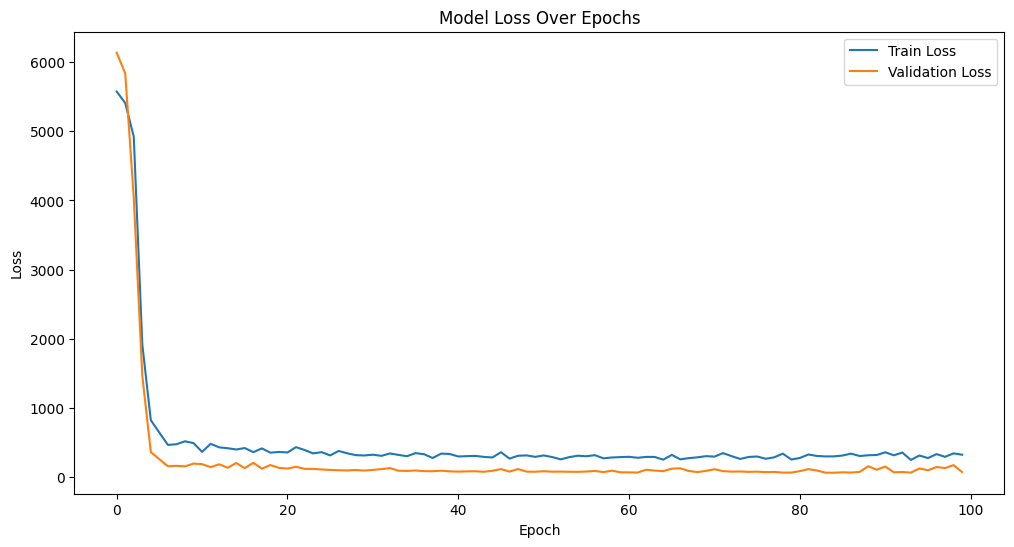

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Traditional ML Classifier

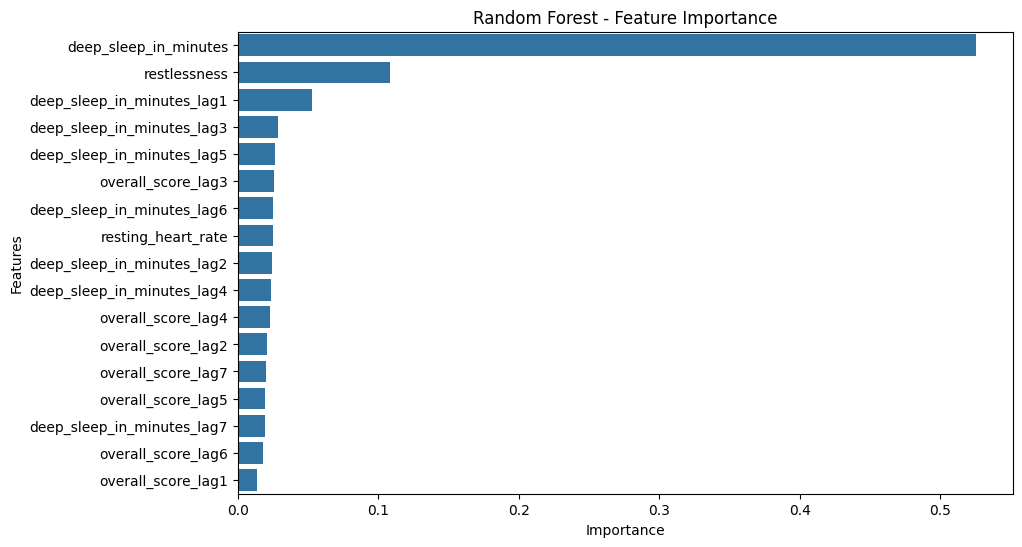

In [ ]:
# Feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(features, target)

importances = rf.feature_importances_
importances_series = pd.Series(importances, index=features_columns)
sorted_importances = importances_series.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest - Feature Importance')
plt.show()

In [ ]:
# Binning deep sleep based on z-scores
mean = df['deep_sleep_in_minutes'].mean()
std_dev = df['deep_sleep_in_minutes'].std()
df['z_score'] = (df['deep_sleep_in_minutes'] - mean) / std_dev
df['deep_sleep_category'] = df['z_score'].apply(lambda z: 'Poor' if z < -1 else ('Average' if z < 1 else 'Good'))


# Binning restlessness based on z-scores
mean_restlessness = df['restlessness'].mean()
std_dev_restlessness = df['restlessness'].std()
df['z_score_restlessness'] = (df['restlessness'] - mean_restlessness) / std_dev_restlessness
df['restlessness_category'] = df['z_score_restlessness'].apply(lambda z: 'Low' if z < -1 else ('Average' if z < 1 else 'High'))

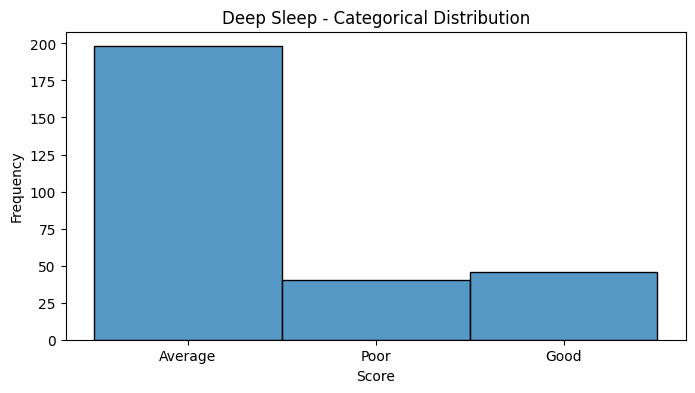

In [ ]:
# Distribution of Deep Sleep - Categorical Variable
plt.figure(figsize=(8, 4))
sns.histplot(df['deep_sleep_category'], kde=False, bins=20)
plt.title('Deep Sleep - Categorical Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

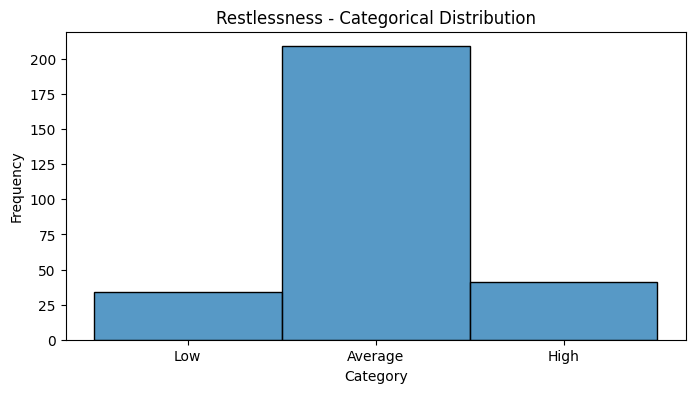

In [ ]:
# Plot the distribution of the restlessness categories
plt.figure(figsize=(8, 4))
sns.histplot(df['restlessness_category'], kde=False, bins=20)
plt.title('Restlessness - Categorical Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()